Driver Distraction Classification



Driver Distraction Monitoring
This notebook is for the classification of driver behavior. We will do image pre-processing and use Deep learning CNN for identifying the behavior of the driver. Which is necessary for handling the unexpected road accident.

Nowadays vehicles are increasing exponentially. We need to be extra careful about the road incident. As there are a couple of things around you, which can distract the driving. We can use this model and implement a smart system, which will monitor driver activities at the time of driving and can alert him about the activities. It will reduce the number of roads accidents and will increase road safety.

State Farm Distracted Driver Detection has divided driving behavior into 10 classes. CLASS Description

C0 Safe Driving

C1 Texting - Right

C2 Talking On The Phone - Right

C3 Texting- left

C4 Talking on the Phone- left

C5 Operating The Radio

C6 Drinking

C7 Reaching Behind

C8 Hair And Makeup

C9 Talking To Passenger

We will implement a deep learning model, which will predict the driver activities at the time of driving.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import gc
import glob
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.activations import elu, softmax
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import BatchNormalization, Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [0]:
kaggleDir = '/content/drive/Shared drives/Tensors/DL/'
train_img_dir = 'drivers/train/'
test_img_dir = 'drivers/test/'
CLASSES = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
           "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
           "c8": "hair and makeup", "c9": " talking to passenger"}
IMG_DIM = 299
CHANNEL_SIZE = 3
SEED_VAL = 41
BATCH_SIZE = 50
EPOCHS = 20  # Tootal Number of epoch


In [0]:
img_rows = 224
img_cols = 224

In [0]:
tf.set_random_seed(SEED_VAL)
gc.enable()
np.random.seed(SEED_VAL)
random.seed(SEED_VAL)

In [0]:


df_train = pd.read_csv(kaggleDir + 'driver_imgs_list.csv', low_memory=True)
print('Number of Samples in trainset : {}'.format(df_train.shape[0]))
print('Number Of districted Classes : {}'.format(len((df_train.classname).unique())))

df_train = shuffle(df_train)



Number of Samples in trainset : 22424
Number Of districted Classes : 10


In [0]:
print("[INFO] : Load all the images.....")
trainImgDir = os.path.join(kaggleDir, train_img_dir)
testImgDir = os.path.join(kaggleDir, test_img_dir)
trainImgs = glob.glob(trainImgDir + '*/*.jpg')
testImgs = glob.glob(testImgDir + '*.jpg')
len(trainImgs), len(testImgs)

[INFO] : Load all the images.....


(18000, 3922)

In [0]:
for x in trainImgs:
    print(x)
    break

for x in testImgs:
    print(x)
    break

/content/drive/Shared drives/Tensors/DL/drivers/train/c0/img_10997.jpg
/content/drive/Shared drives/Tensors/DL/drivers/test/img_384.jpg


In [0]:
# Display top five record in csv
df_train.head()

,subject,classname,img
15104,p050,c6,img_95325.jpg
13940,p049,c4,img_38128.jpg
3115,p015,c7,img_62528.jpg
599,p002,c7,img_39755.jpg
3875,p016,c5,img_69053.jpg


In [0]:
# Dispaly Last five samples from CSV.
df_train.tail()

,subject,classname,img
8513,p026,c3,img_72027.jpg
21584,p075,c9,img_64627.jpg
20450,p072,c0,img_47528.jpg
931,p012,c2,img_85044.jpg
1984,p014,c4,img_23408.jpg


# BarPlot and PieChart



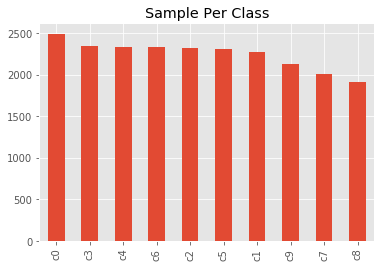

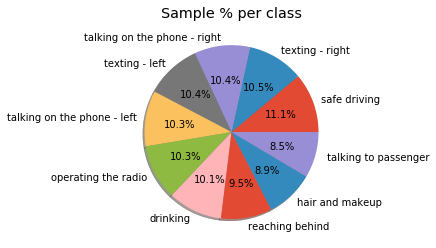

In [0]:
class_freq_count = df_train.classname.value_counts()

class_freq_count.plot(kind='bar', label='index')
plt.title('Sample Per Class');
plt.show()

plt.pie(class_freq_count, autopct='%1.1f%%', shadow=True, labels=CLASSES.values())
plt.title('Sample % per class');
plt.show()

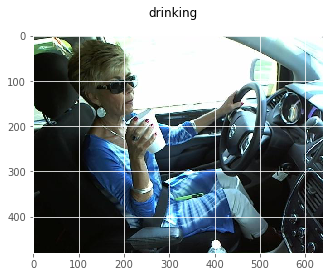

In [0]:
imgPath = os.path.join(kaggleDir, train_img_dir, "c6/img_20687.jpg")
img = load_img(imgPath)
plt.suptitle(CLASSES['c6'])
plt.imshow(img)

In [0]:
def draw_driver(imgs, df, classId='c0'):
    fig, axis = plt.subplots(2, 3, figsize=(20, 7))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgPath = os.path.join(kaggleDir, train_img_dir, f"{classId}/{row['img']}")
        row = idnx // 3
        col = idnx % 3 
        img = load_img(imgPath)
        #         img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        plt.imshow(img)
        axis[row, col].imshow(img)
    plt.suptitle(CLASSES[classId])
    plt.show()


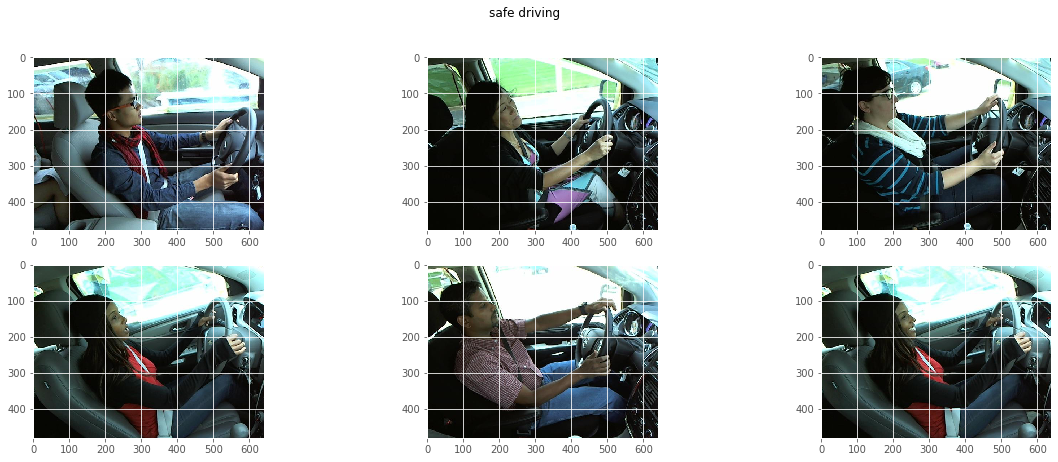

In [0]:
draw_driver(df_train[df_train.classname == 'c0'].head(6), df_train, classId='c0')

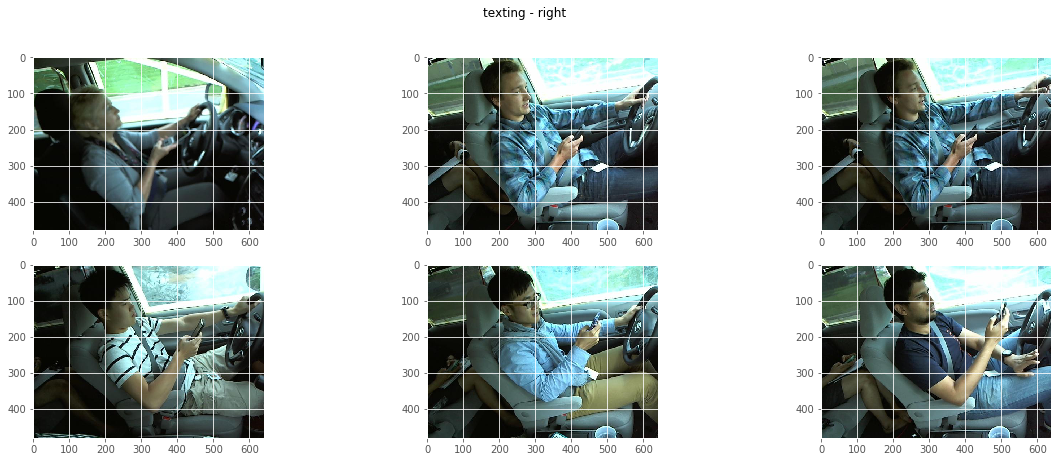

In [0]:
draw_driver(df_train[df_train.classname == 'c1'].head(6), df_train, classId='c1')

# Image Pre-Processing

In [0]:
dfY = df_train.classname
x_train, x_test, y_train, y_test = train_test_split(df_train, dfY, test_size=0.15, stratify=dfY)
print('Number of Samples in XTrain : {} Ytrain: {}'.format(x_train.shape[0], y_train.shape[0]))
print('Number of Samples in Xtest : {} Ytest: {}'.format(x_test.shape[0], y_test.shape[0]))

Number of Samples in XTrain : 19060 Ytrain: 19060
Number of Samples in Xtest : 3364 Ytest: 3364


In [0]:
df_train.head()

,subject,classname,img
15104,p050,c6,img_95325.jpg
13940,p049,c4,img_38128.jpg
3115,p015,c7,img_62528.jpg
599,p002,c7,img_39755.jpg
3875,p016,c5,img_69053.jpg


In [0]:
df_train['file_name']=df_train.img.apply(lambda  x:x[:-4])

In [0]:
df_train.head()

,subject,classname,img,file_name
15104,p050,c6,img_95325.jpg,img_95325
13940,p049,c4,img_38128.jpg,img_38128
3115,p015,c7,img_62528.jpg,img_62528
599,p002,c7,img_39755.jpg,img_39755
3875,p016,c5,img_69053.jpg,img_69053


In [0]:
class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        #         print("[INFO] : Simple PreProcessor invoked...!")
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        #         print("[INFO] : Prepossess Resizing invoked...!")
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

In [0]:
class ImageToArrayPreprocessor:
    def __init__(self, dataFormat=None):
        self.dataFormat = dataFormat

    def preprocess(self, image):
        return img_to_array(image, data_format=self.dataFormat)

In [0]:
class SimpleDataLoader:
    def __init__(self, preprocessors=None):
        self.preprocessors = preprocessors
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, trainImgs, verbose=-1):
        imgData = []
        imgLabels = []
        for (idx, imgPath) in enumerate(trainImgs):
            tmpImg = cv2.imread(imgPath)
            classLabel = imgPath.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for preprocesor in self.preprocessors:
                    img = preprocesor.preprocess(tmpImg)
                    gc.collect()
                imgData.append(tmpImg)
                imgLabels.append(imgLabels)

            if verbose > 0 and idx > 0 and (idx + 1) % verbose == 0:
                print('[INFO]: Processed {}/{}'.format((idx + 1), len(trainImgs)))
        print(len(imgData), len(imgLabels))
        return np.array(imgData), np.array(imgLabels)

In [0]:
print("[INFO] : Loading data from desk and scale the raw pixel intensities to the range [0,1] ....!")


[INFO] : Loading data from desk and scale the raw pixel intensities to the range [0,1] ....!


# Data Augmentation
Data Augmentation is the technique to generate new sample from the existing sample. So, you can reduce generalization error. It will genrerate natrual sample. There are number of features, which can help you in data agumentation.

rotation_range : is a value in degrees (0-180), a range within which to randomly rotate pictures.

height_shift_range : Constructor control the amount of horizontal and vertical shift respectively.

width_shift_range : Constructor control the amount of horizontal and vertical shift respectively.

shear_range : Shear Intensity (Shear angle in counter-clockwise direction in degrees)

zoom_range : Range for random zoom

horizontal_flip : Randomly filp of input image in horizontally. But we can't use in our case. It can chane the class of images.

fill_mode : Points outside the boundaries of the input image are filled according to the given mode. (default Nearest)

In [0]:
imgPath = os.path.join(kaggleDir, train_img_dir, "c6/img_20687.jpg")
image=load_img(imgPath)
image=img_to_array(image)
image=np.expand_dims(image, axis=0)
generator = ImageDataGenerator(rotation_range=30,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               shear_range=0.2,
                               zoom_range=0.2,
#                                horizontal_flip=True,
                               fill_mode='nearest') 
imageGen=generator.flow(image,batch_size=1)

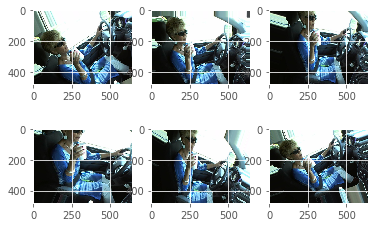

In [0]:


for i in range(6):
    nextImg=imageGen.next()
    plt.subplot(230 + 1 + i)
    image = nextImg[0].astype('uint8')
    plt.imshow(image)
plt.show()



In [0]:
generator = ImageDataGenerator(rescale=1 / 255.0,
                               zoom_range=30,
                               samplewise_center=True,
                               height_shift_range=0.2,
                               width_shift_range=0.2,
                               shear_range=0.2, 
                               fill_mode='nearest',
                               validation_split=0.15)

In [0]:


train_generator = generator.flow_from_directory(directory=os.path.join(kaggleDir, train_img_dir),
                                                classes=CLASSES.keys(),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                target_size=(IMG_DIM, IMG_DIM),
                                                shuffle=True,
                                                seed=SEED_VAL,
                                                subset='training')
valid_generator = generator.flow_from_directory(directory=os.path.join(kaggleDir, train_img_dir),
                                                classes=CLASSES.keys(),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                target_size=(IMG_DIM, IMG_DIM),
                                                shuffle=True,
                                                seed=SEED_VAL,
                                                subset='validation')
train_generator.class_indices
gc.collect()



Found 15305 images belonging to 10 classes.
Found 2695 images belonging to 10 classes.


25773

In [0]:
train_generator.class_indices,valid_generator.samples

({'c0': 0,
  'c1': 1,
  'c2': 2,
  'c3': 3,
  'c4': 4,
  'c5': 5,
  'c6': 6,
  'c7': 7,
  'c8': 8,
  'c9': 9},
 2695)

In [0]:
trainImgs[:5]

['/content/drive/Shared drives/Tensors/DL/drivers/train/c0/img_10997.jpg',
 '/content/drive/Shared drives/Tensors/DL/drivers/train/c0/img_72874.jpg',
 '/content/drive/Shared drives/Tensors/DL/drivers/train/c0/img_87355.jpg',
 '/content/drive/Shared drives/Tensors/DL/drivers/train/c0/img_5514.jpg',
 '/content/drive/Shared drives/Tensors/DL/drivers/train/c0/img_88072.jpg']

# Keras Callbacks Functions

In [0]:
earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=8, verbose=1, min_delta=0.0000001)
reduceRL = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.001, min_delta=0.0001, verbose=1,
                             min_lr=1e-6)
callbacks = [reduceRL]  # earlyStop

# Neural Network Architecture

In [0]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=[IMG_DIM, IMG_DIM, 1], activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation=elu))
# model.add(Activation(activation=elu))
# model.add(MaxPooling2D())
# model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dense(3000))
model.add(Activation(activation=elu))
model.add(Dropout(rate=0.25))
model.add(Dense(2000))
model.add(Activation(activation=elu))
model.add(Dropout(rate=0.25))
model.add(Dense(len(CLASSES)))
model.add(Activation(activation=softmax))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 297, 297, 32)      320       
_________________________________________________________________
activation_19 (Activation)   (None, 297, 297, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 148, 148, 32)      0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 148, 148, 32)      128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
activation_20 (Activation)   (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 73, 73, 32)       

In [0]:
# opt = SGD()#lr=0.0001
from keras.optimizers import adam
opt=adam()
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc'])

In [0]:
History = model.fit_generator(train_generator,
                              steps_per_epoch=train_generator.samples // BATCH_SIZE,
                              validation_data=valid_generator,
                              validation_steps=valid_generator.samples // BATCH_SIZE,
                              epochs=EPOCHS,
                              verbose=1).history  
                              #callbacks=callbacks

Epoch 1/20
306/306 [==============================] - 145s 474ms/step - loss: 2.5299 - acc: 0.1385 - val_loss: 2.1882 - val_acc: 0.1421
Epoch 2/20
306/306 [==============================] - 139s 453ms/step - loss: 2.1471 - acc: 0.1392 - val_loss: 2.2207 - val_acc: 0.1341
Epoch 3/20
306/306 [==============================] - 138s 449ms/step - loss: 2.1380 - acc: 0.1411 - val_loss: 2.1257 - val_acc: 0.1297
Epoch 4/20
306/306 [==============================] - 138s 450ms/step - loss: 2.1304 - acc: 0.1405 - val_loss: 2.1478 - val_acc: 0.1472
Epoch 5/20
306/306 [==============================] - 136s 446ms/step - loss: 2.1526 - acc: 0.1425 - val_loss: 2.1718 - val_acc: 0.1335
Epoch 6/20
306/306 [==============================] - 137s 447ms/step - loss: 2.1980 - acc: 0.1321 - val_loss: 2.1671 - val_acc: 0.1409
Epoch 7/20
306/306 [==============================] - 136s 446ms/step - loss: 2.1353 - acc: 0.1416 - val_loss: 2.1437 - val_acc: 0.1406
Epoch 8/20
306/306 [============================

In [0]:
eval_loss, eval_acc = model.evaluate_generator(valid_generator, steps=valid_generator.samples / BATCH_SIZE);
print('[INFO] : Evaluation Accuracy : {:.2f}%'.format(eval_acc * 100))
print('[INFO] : Evaluation Loss : {}'.format(eval_loss))

[INFO] : Evaluation Accuracy : 14.53%
[INFO] : Evaluation Loss : 2.157208361007549


# Training Accurcy / Loss


In [0]:
History.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

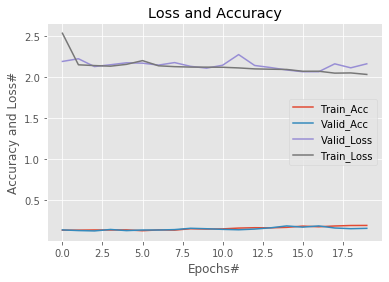

In [0]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, EPOCHS), History['acc'], label='Train_Acc')

plt.plot(np.arange(0, EPOCHS), History['val_acc'], label='Valid_Acc')
plt.plot(np.arange(0, EPOCHS), History['val_loss'], label='Valid_Loss')
plt.plot(np.arange(0, EPOCHS), History['loss'], label='Train_Loss')
plt.xlabel('Epochs#')
plt.ylabel('Accuracy and Loss#')
plt.title("Loss and Accuracy")
plt.legend()
plt.show()


**Import Libraries**


In [0]:
import gc
import glob
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.activations import elu, softmax
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import BatchNormalization, Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Hypermeter and Variable

In [0]:
kaggleDir = '/content/drive/Shared drives/Tensors/DL/'
train_img_dir = 'train/'
test_img_dir = 'test/'
CLASSES = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
           "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
           "c8": "hair and makeup", "c9": " talking to passenger"}
IMG_DIM = 299
CHANNEL_SIZE = 3
SEED_VAL = 41
BATCH_SIZE = 50
EPOCHS = 2  # Tootal Number of epoch


# Import Dataset

In [0]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [0]:
dataset = pd.read_csv('/content/drive/Shared drives/Tensors/DL/driver_imgs_list.csv', low_memory=True)
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [0]:
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [0]:
from os.path import join
from glob import glob
NUMBER_CLASSES = 10
# Color type: 1 - grey, 3 - rgb

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

# Training
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('/content/drive/Shared drives/Tensors/DL/drivers/train', 'c' + str(classed), '*.jpg'))
        print('Getting jpg')
        for file in files:
            
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=40)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('/content/drive/Shared drives/Tensors/DL/drivers/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [0]:
img_rows = 64
img_cols = 64
color_type = 1
# !pip install scikit-learn==0.19.1

In [0]:
nx_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', nx_train.shape)
print(nx_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0
Getting jpg


 10%|█         | 1/10 [22:27<3:22:04, 1347.21s/it]

Loading directory c1
Getting jpg


 20%|██        | 2/10 [42:04<2:52:50, 1296.29s/it]

Loading directory c2
Getting jpg
Loading directory c3
Getting jpg


 40%|████      | 4/10 [1:03:46<1:50:15, 1102.60s/it]

Loading directory c4
Getting jpg


 50%|█████     | 5/10 [1:24:49<1:35:53, 1150.74s/it]

Loading directory c5
Getting jpg


 60%|██████    | 6/10 [1:26:08<55:17, 829.29s/it]   

Loading directory c6
Getting jpg


 70%|███████   | 7/10 [1:47:41<48:24, 968.31s/it]

Loading directory c7
Getting jpg


 80%|████████  | 8/10 [2:07:29<34:28, 1034.42s/it]

Loading directory c8
Getting jpg


 90%|█████████ | 9/10 [2:24:09<17:04, 1024.15s/it]

Loading directory c9
Getting jpg


100%|██████████| 10/10 [2:43:22<00:00, 1062.75s/it]

Data Loaded in 9802.717492818832 second
Train shape: (14400, 64, 64, 1)
14400 train samples


In [0]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  5%|▌         | 200/3922 [01:50<32:34,  1.90it/s]

Test shape: (200, 64, 64, 1)
200 Test samples


#Data Visualization

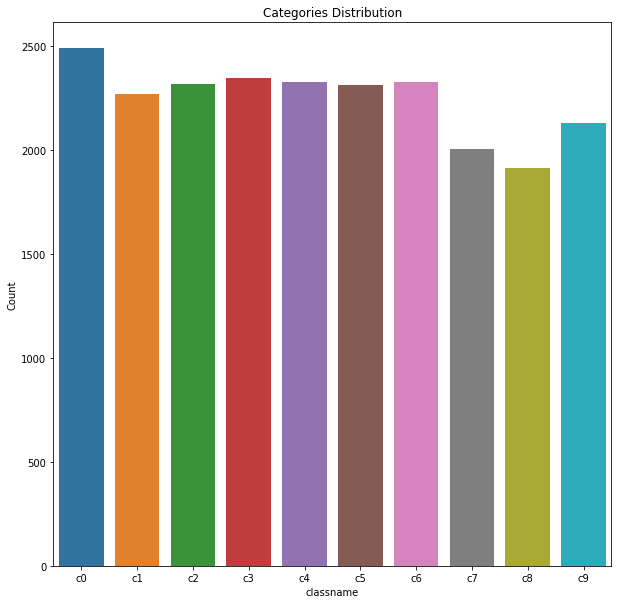

In [0]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [0]:
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


<Figure size 1440x1440 with 0 Axes>

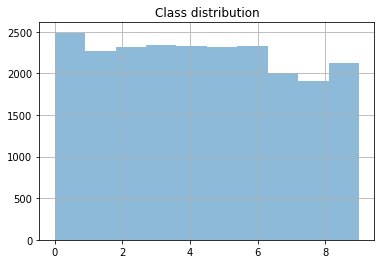

In [0]:
# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

# Image Overview

In [0]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

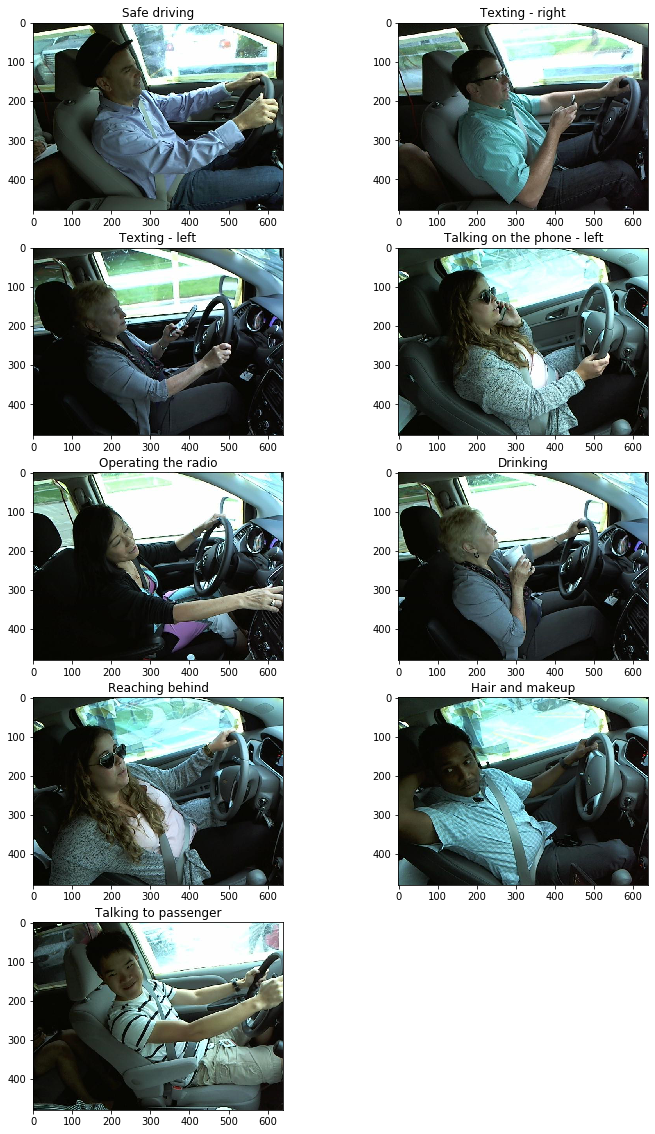

In [0]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '/content/drive/Shared drives/Tensors/DL/drivers/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [0]:
def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    
    now = datetime.datetime.now()
    
    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

    suffix = "{}_{}".format(info,str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')
    
    result.to_csv(sub_file, index=False)
    
    return sub_file

# Create Vanilla Model
**Building the model**

we'll develop the model with a total of 4 Convolutional layers, then a Flatten layer and then 2 Dense layers. we'll use the optimizer as rmsprop, and loss as categorical_crossentropy.

In [0]:
batch_size = 40
nb_epoch = 10

In [0]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [0]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

Model V1

In [0]:

def create_model_v1():
    # Vanilla CNN model
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 256, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 512, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))
    
    return model

In [0]:
model_v1 = create_model_v1()

# More details about the layers
model_v1.summary()

# Compiling the model
model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 256)         0         


In [0]:

# Training the Vanilla Model version 1
history_v1 = model_v1.fit(nx_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 14400 samples, validate on 3600 samples
Epoch 1/10





14400/14400 [==============================] - 24s 2ms/step - loss: 14.2364 - acc: 0.1165 - val_loss: 14.2735 - val_acc: 0.1144

Epoch 00001: val_loss improved from inf to 14.27347, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 2/10
14400/14400 [==============================] - 16s 1ms/step - loss: 14.4414 - acc: 0.1040 - val_loss: 14.2735 - val_acc: 0.1144

Epoch 00002: val_loss did not improve from 14.27347
Epoch 3/10
14400/14400 [==============================] - 16s 1ms/step - loss: 14.4425 - acc: 0.1040 - val_loss: 14.2735 - val_acc: 0.1144

Epoch 00003: val_loss did not improve from 14.27347
Epoch 00003: early stopping


In [0]:
model_v1.load_weights('saved_models/weights_best_vanilla.hdf5')

In [0]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

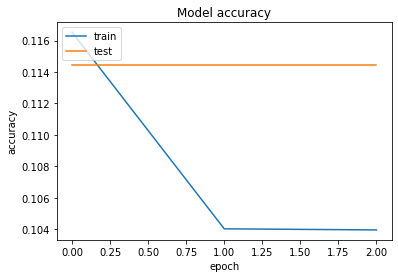

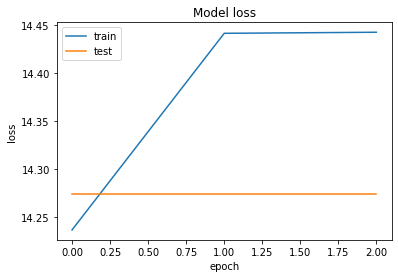

In [0]:
plot_train_history(history_v1)

In [0]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [0]:
score = model_v1.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

3600/3600 [==============================] - 1s 404us/step
Score:  [14.273468822903103, 0.11444444444444445]


1/1 [==============================] - 0s 140ms/step
Y prediction: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted: Hair and makeup


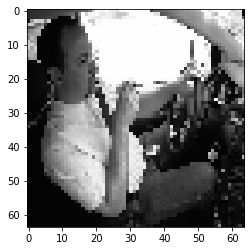

In [0]:
plot_test_class(model_v1, test_files, 20)

#Create a vanilla CNN model with data augmentation
Here I'm augmenting the previous model classifier, I'll use the data on which I want to train the model. The folder train includes the images I need. I'll generate more images using ImageDataGenerator and split the training data into 80% train and 20% validation split.

In [0]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [0]:
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [0]:
nb_train_samples = nx_train.shape[0]
nb_validation_samples = x_test.shape[0]
print(nb_train_samples)
print(nb_validation_samples)
training_generator = train_datagen.flow(nx_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

NameError: ignored

In [0]:
checkpoint = ModelCheckpoint('saved_models/weights_best_vanilla.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v3 = model_v1.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
360/360 [==============================] - 17s 46ms/step - loss: 2.4569 - acc: 0.2099 - val_loss: 1.3904 - val_acc: 0.4758

Epoch 00001: val_acc improved from -inf to 0.47583, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 2/5
360/360 [==============================] - 16s 45ms/step - loss: 1.0942 - acc: 0.6039 - val_loss: 0.5148 - val_acc: 0.8361

Epoch 00002: val_acc improved from 0.47583 to 0.83611, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 3/5
360/360 [==============================] - 16s 45ms/step - loss: 0.6164 - acc: 0.7934 - val_loss: 0.3460 - val_acc: 0.8869

Epoch 00003: val_acc improved from 0.83611 to 0.88694, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 4/5
360/360 [==============================] - 16s 45ms/step - loss: 0.4300 - acc: 0.8596 - val_loss: 0.1694 - val_acc: 0.9553

Epoch 00004: val_acc improved from 0.88694 to 0.95528, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 5/5
360/360 [========

In [0]:
model_v1.load_weights('saved_models/weights_best_vanilla.hdf5')

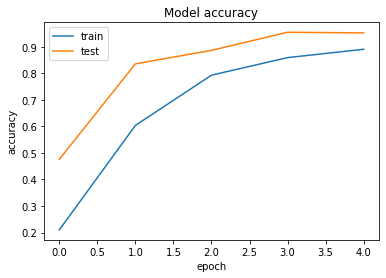

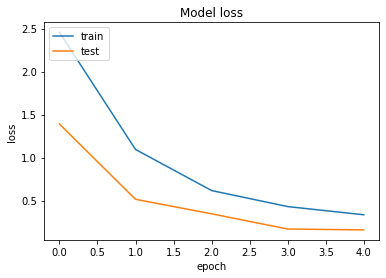

In [0]:
plot_train_history(history_v3)

In [0]:
# Evaluate the performance of the new model
score = model_v1.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.169444097744094
Test Accuracy: 0.955277783340878


1/1 [==============================] - 0s 3ms/step
Y prediction: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted: Hair and makeup


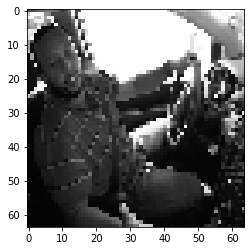

In [0]:
plot_test_class(model_v1, test_files, 101)


Transfer learning with VGG net

In [0]:
def vgg_std16_model(img_rows, img_cols, color_type=3):
    nb_classes = 10
    # Remove fully connected layer and replace
    # with softmax for classifying 10 classes
    vgg16_model = VGG16(weights="imagenet", include_top=False)

    # Freeze all layers of the pre-trained model
    for layer in vgg16_model.layers:
        layer.trainable = False
        
    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(nb_classes, activation = 'softmax')(x)

    model = Model(input = vgg16_model.input, output = predictions)
    
    return model

In [0]:
# Load the VGG16 network
print("Loading network...")
model_vgg16 = vgg_std16_model(img_rows, img_cols)

model_vgg16.summary()

model_vgg16.compile(loss='categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

Loading network...
58892288/58889256 [==============================] - 5s 0us/step






Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
___________________________________

In [0]:
training_generator = train_datagen.flow_from_directory('/content/drive/Shared drives/Tensors/DL/drivers/train', 
                                                 target_size = (img_rows, img_cols), 
                                                 batch_size = batch_size,
                                                 shuffle=True,
                                                 class_mode='categorical', subset="training")

validation_generator = test_datagen.flow_from_directory('/content/drive/Shared drives/Tensors/DL/drivers/train', 
                                                   target_size = (img_rows, img_cols), 
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical', subset="validation")
nb_train_samples = 17943
nb_validation_samples = 4481

In [0]:
!rm -f saved_models/weights_best_vgg16.hdf5

In [0]:
checkpoint = ModelCheckpoint('saved_models/weights_best_vgg16.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v4 = model_vgg16.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         class_weight='auto',
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

In [0]:
model_vgg16.load_weights('saved_models/weights_best_vgg16.hdf5')

In [0]:
# Evaluate the performance of the new model
score = model_vgg16.evaluate_generator(validation_generator, nb_validation_samples // batch_size, verbose = 1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])